The following work is mainly inspired by:
- 2014 - Convolutional Neural Networks for Sentence Classification
- 2014 - A Convolutional Neural Network for Modelling Sentences
- 2017 - Self-Taught Convolutional Neural Networks for Short Text Clustering

Word embedding from fasttext are distributed under the license:
- Creative Commons Attribution-Share-Alike License 3.0 (free commercial use)

# Import

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

src_emb = "c://projets_willy/01 word embedding/"
src_stc = "c://projets_willy/02 data/01 short_text_clustering/"
src_mr = "c://projets_willy/02 data/03 movie_review"

In [2]:
os.listdir("c://projets_willy/02 data/")

['00 verbatim',
 '01 short_text_clustering',
 '02 bank_of_the_west',
 '03 movie_review']

In [3]:
# Dataset for movie review sentiment analysis
os.listdir(src_mr)

['rt-polaritydata', 'txt_sentoken']

In [4]:
# Dataset for short text clustering (stc)
os.listdir(src_stc)

['Biomedical-lite.mat',
 'Biomedical-STC2.mat',
 'Biomedical.txt',
 'Biomedical_gnd.txt',
 'Biomedical_index.txt',
 'Biomedical_vocab2idx.dic',
 'SearchSnippets-lite.mat',
 'SearchSnippets-STC2.mat',
 'SearchSnippets.txt',
 'SearchSnippets_gnd.txt',
 'SearchSnippets_index.txt',
 'SearchSnippets_vocab2idx.dic',
 'StackOverflow-lite.mat',
 'StackOverflow-STC2.mat',
 'StackOverflow.txt',
 'StackOverflow_gnd.txt',
 'StackOverflow_index.txt',
 'StackOverflow_vocab2idx.dic']

In [5]:
# Word embedding 
os.listdir(src_emb)

['fasttext.wiki.en.vec',
 'fasttext.wiki.fr.bin',
 'fasttext.wiki.fr.vec',
 'glove100K.100d.txt']

# Fetching the data

#### Loading pre-trained Glove word embedding

The file `glove100K.100d.txt` is an extract of [Glove](http://nlp.stanford.edu/projects/glove/) Vectors, that were trained on english Wikipedia 2014 + Gigaword 5 (6B tokens).

We extracted the `100 000` most frequent words. They have a dimension of `100`

``` 
glove_embeddings_index = {}
glove_embeddings_vectors = []

with open(src_emb + 'glove100K.100d.txt', 'rb') as f:
    word_idx = 0
    for line in f:
        values = line.decode('utf-8').split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = word_idx
        glove_embeddings_vectors.append(vector)
        word_idx = word_idx + 1

glove_inv_index = {v: k for k, v in glove_embeddings_index.items()}
print("found %d different words in the file" % word_idx) # Fetching word embedding from the web
```

#### Loading pre-trained Fasttext word embedding

Pre-trained word vectors for french languages, trained on Wikipedia using fastText. These vectors in dimension `300` were obtained using the skip-gram model described in `Bojanowski et al.(2016)` with default parameters.

We extracted the `100 000` most frequent words. They have a dimension of `300`

In [6]:
%%time

"""
500 000 words: 50s
200 000 words: 20s
300 000 words: 30s
100 000 words: 10s
"""

fast_embeddings_index = {}
fast_embeddings_vectors = []
total = 3 * int(1e5)

with open(src_emb + 'fasttext.wiki.en.vec', 'rb') as f:
    head = f.readline()
    for word_idx in range(total):
        raw = f.readline().decode('utf-8').rstrip(' \n')
        line = raw.split(' ')
        word = line[0]
        vector = np.asarray(line[1:], dtype='float32')
        fast_embeddings_index[word] = word_idx
        fast_embeddings_vectors.append(vector)
        
fast_inv_index = {v: k for k, v in fast_embeddings_index.items()}
print("found %d different words in the file" % total)

found 300000 different words in the file
Wall time: 39.4 s


In [7]:
# Storing each embedding model
embedding_model = {}
embedding_model['fasttext'] = [fast_embeddings_index, fast_embeddings_vectors, fast_inv_index]
#embedding_model['glove'] = [glove_embeddings_index, glove_embeddings_vectors, glove_inv_index]

# Word embedding

In [8]:
#embedding_name = 'glove'
embedding_name = 'fasttext'
embeddings_index, embeddings_vectors, inv_index = embedding_model[embedding_name]

In [9]:
# Stack all embeddings in a large numpy array
embeddings = np.vstack(embeddings_vectors)
norms = np.linalg.norm(embeddings, axis=-1, keepdims=True)
embeddings_normed = embeddings / norms
print(embeddings.shape)

(300000, 300)


In [10]:
# Create a random embedding shape for word
emb_shape = np.shape(embeddings[0])
mu = 0
sigma = 0.1

# Randomly initialize with normal distribution
def rand_init():
    return np.zeros(shape=emb_shape)

In [11]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return rand_init()
    else:
        return embeddings[idx]

def get_normed_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return rand_init()
    else:
        return embeddings_normed[idx]

In [1]:
epsilon = 1e-5

def most_similar(words, topn=10):
    query_emb = 0
    # If we have a list of words instead of one word
    if type(words) == list:
        for word in words:
            query_emb += get_emb(word)       
    else:
        query_emb = get_emb(words)
        
    query_emb = query_emb / (np.linalg.norm(query_emb) + epsilon)
    
    # Large numpy vector with all cosine similarities
    # between emb and all other words
    cosines = np.dot(embeddings_normed, query_emb)
    
    # topn most similar indexes corresponding to cosines
    idxs = np.argsort(cosines)[::-1][:topn]
    
    # pretty return with word and similarity
    return [(inv_index[idx], cosines[idx]) for idx in idxs]

In [13]:
most_similar('paribas')

[('paribas', 0.99999827),
 ('bnp', 0.73437661),
 ('banque', 0.62403095),
 ('crédit', 0.62366718),
 ('unicredit', 0.61449575),
 ('amro', 0.6123848),
 ('hsbc', 0.58770335),
 ('medibank', 0.5833407),
 ('aegon', 0.5831418),
 ('wta', 0.5829525)]

In [14]:
most_similar('mitterrand')

[('mitterrand', 0.99999797),
 ('chirac', 0.82997411),
 ('giscard', 0.73779279),
 ('villepin', 0.72653931),
 ('sarkozy', 0.7191276),
 ('hollande', 0.71666515),
 ('fillon', 0.70724654),
 ('chevènement', 0.70392537),
 ('juppé', 0.685969),
 ('gaullist', 0.6837129)]

# Data exploration

#### Loading data

In [15]:
#data_name = "Biomedical"
data_name = "StackOverflow"

with open(src_stc + '%s.txt' % data_name, encoding="utf-8") as f:
    data = f.readlines()
data = [text.rstrip('\n') for text in data]

with open(src_stc + '%s_gnd.txt' % data_name, encoding="utf-8") as f:
    target = f.readlines()
target = [int(label.rstrip('\n')) for label in target]
    
print("short texts")
n_max = 10
__ = [print("%d --" %label, txt) for txt, label in zip(data[:n_max], target[:n_max])]
print("\n Total: %s texts" % format(len(data), ","))

short texts
18 -- How do I fill a DataSet or a DataTable from a LINQ query resultset ?
18 -- How do you page a collection with LINQ?
3 -- Best Subversion clients for Windows Vista (64bit)
3 -- Best Practice: Collaborative Environment, Bin Directory, SVN
7 -- Visual Studio Setup Project - Per User Registry Settings
18 -- How do I most elegantly express left join with aggregate SQL as LINQ query
7 -- .Net XML comment into API Documentation
15 -- Modify Address Bar URL in AJAX App to Match Current State
7 -- Integrating Visual Studio Test Project with Cruise Control
10 -- What should a longtime Windows user know when starting to use Linux?

 Total: 20,000 texts


In [16]:
# Random sample 

n = len(data)
sample = 10000
print("Loading %s samples" % format(sample, ","))
index_sample = np.random.randint(0, n, sample)

data = [data[idx] for idx in index_sample]
target = [target[idx] for idx in index_sample]

Loading 10,000 samples


In [17]:
most_similar('stackoverflow')

[('stackoverflow', 0.99999756),
 ('//stackoverflow', 0.86643362),
 ('stackexchange', 0.7111659),
 ('sourcecode', 0.64328611),
 ('metafilter', 0.63601023),
 ('implementations', 0.60966074),
 ('liquidthreads', 0.60903955),
 ('memcached', 0.60653389),
 ('openmp', 0.6022625),
 ('codeplex', 0.599213)]

#### Splitting dataset into train-test

In [18]:
from sklearn.model_selection import train_test_split

# train test split of dataset
train, test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)
print("train size: %d" % len(train))
print("test size: %d" % len(test))

train size: 9000
test size: 1000


In [19]:
from keras.preprocessing.text import Tokenizer

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(train)
sequences_train = tokenizer.texts_to_sequences(train)
sequences_test = tokenizer.texts_to_sequences(test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

MAX_NB_WORDS = len(word_index)

Using TensorFlow backend.


Found 6687 unique tokens.


#### Let's look at the length of the data

average length: 8.6
max length: 33


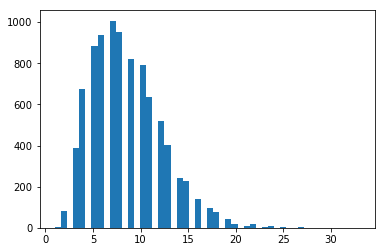

In [20]:
seq_lens = [len(s) for s in sequences_train]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))
plt.hist(seq_lens, bins=50);

In [21]:
from keras.preprocessing.sequence import pad_sequences

# according to previous cell
MAX_SEQUENCE_LENGTH = max(seq_lens)

# pad sequences with 0s
X_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', np.shape(X_train))
print('Shape of data test tensor:', np.shape(X_test))

Shape of data tensor: (9000, 33)
Shape of data test tensor: (1000, 33)


In [22]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(np.asarray(y_train))
Y_test = to_categorical(np.asarray(y_test))
print('Shape of label tensor:', Y_train.shape)
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (9000, 21)
Shape of label tensor: (1000, 21)


In [23]:
# creating embedding matrix

EMBEDDING_DIM = emb_shape[0]
N_CLASSES = 21

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = get_emb(word)
    embedding_matrix[i] = embedding_vector
    nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 6687 words in the embedding matrix


# CNN

In [24]:
from keras.layers import Input, Embedding, Flatten, Reshape
from keras.layers import Dense, Conv1D, Dropout, merge
from keras.layers import GlobalAveragePooling1D, AveragePooling1D
from keras.layers import MaxPooling1D, GlobalMaxPooling1D, ZeroPadding1D
from keras.models import Model

# Note, on this type of task, this technique will 
# degrade results as we train much less parameters
# and we average a large number pre-trained embeddings.
# You will notice much less overfitting then!
# Using convolutions / LSTM will help
# It is also advisable to treat seperately pre-trained
# embeddings and words out of vocabulary.

In [25]:
embedding_matrix_copy = embedding_matrix.copy()
trainable_layer = True

# Embedding layer
pretrained_embedding_layer = Embedding(
    input_dim=MAX_NB_WORDS+1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

# Input
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)

# Layer
x = Conv1D(100, 5, activation='relu')(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)

# Output
predictions = Dense(N_CLASSES, activation='softmax')(x)
model = Model(sequence_input, predictions)

# Fine-tune embeddings or not
model.layers[1].trainable=trainable_layer

# Model hyper-parameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#model.summary()

In [26]:
%%time
model.fit(X_train, Y_train, validation_split=0.1,
          nb_epoch=1, batch_size=128, verbose=2)

Train on 8100 samples, validate on 900 samples
Epoch 1/1
16s - loss: 1.7869 - acc: 0.6177 - val_loss: 0.7723 - val_acc: 0.8356
Wall time: 16.9 s


In [27]:
from sklearn.metrics import accuracy_score
proba = model.predict(X_test)
pred = np.argmax(proba, axis=1)
acc = accuracy_score(y_test, pred)*100
print("Accuracy: %0.02f pct" % acc)

Accuracy: 80.50 pct


# Deep feature representations learning

In [28]:
""" Be careful, dataset was shuffled during train-test split. """
# sequences
n_train = len(sequences_train)
n_test = len(sequences_test)
sequences = sequences_train + sequences_test
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
Y = dict()

# tf-idf
tfidf = tokenizer.sequences_to_matrix(sequences, mode='tfidf')

# label
y = y_train + y_test

# dictionary of reduction methods' name
reduction_methods = {"le": "laplacian eigenvalues",
                     "ae": "average embeddings",
                     "lsa": "latent semantic analysis"}

#### Average embeddings (AE)

``
%%time
denom = 1 + np.sum(tfidf, axis=1)[:, None]
normed_tfidf = tfidf/denom
average_embeddings = np.dot(normed_tfidf, embedding_matrix)
Y["ae"] = average_embeddings
print("Shape of average embedding: ", Y['ae'].shape)
``

#### Latent Semantic Analysis (LSA)

In [29]:
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
%%time
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
L = lsa.fit_transform(tfidf)
Y["lsa"] = L
print("Shape of latent semantic vectors: ", Y['lsa'].shape)

Shape of latent semantic vectors:  (10000, 100)
Wall time: 10.5 s


#### Laplacian Eigenmaps (LE)

In [31]:
from sklearn.manifold import SpectralEmbedding
from sklearn.neighbors import NearestNeighbors

In [32]:
%%time
# KNN using LSA representations
nn = NearestNeighbors(n_neighbors=15)
nn.fit(L)
G = nn.kneighbors_graph(mode="distance").toarray()

Wall time: 29.7 s


In [ ]:
%%time
# creation of affinity matrix
index_A = G.T != 0
A = G.copy()
A[index_A] = G.T[index_A]

# heat kernel affinity matrix
index_nnull = A != 0
A[index_nnull] = np.exp(-A[index_nnull]/2.)
A += np.identity(np.shape(A)[0])

Wall time: 3.39 s


#### Be careful about line below (very memory intensive)

In [ ]:
%%time 
# spectral embedding
subspace_dimension = 15
spec_emb = SpectralEmbedding(n_components=subspace_dimension, affinity="precomputed")
E = spec_emb.fit_transform(A)

In [ ]:
print(E.shape)
print()
print(E[0])
Y["le"] = E

#### Binary feature

In [ ]:
reduction_name = "le"
U = Y[reduction_name]

# Binarize B
median = np.median(U, axis=1)[:, None]
B = np.zeros(shape=np.shape(U))
B[U > median] = 1

# Last dimension in the CNN
LAST_DIMENSION = B.shape[1]

In [ ]:
print(B.shape)
print()
print(B[0])

In [ ]:
B_train = B[:n_train]
B_test = B[n_train:]

#### CNN for deep feature representation learning 

Remarks:
- Two layers is better
- Activation tanh slightly better than relu
- Setting trainable layer to "True", we achieved in 10 epochs with batch=50 a very good performance (0.32 with current architecture)

To try:
- Use multiple layers

In [ ]:
embedding_matrix_copy = embedding_matrix.copy()
trainable_embedding = False

# Embedding layer
pretrained_embedding_layer = Embedding(
    input_dim=MAX_NB_WORDS+1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

# Input
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)

# 1st Layer
x = Conv1D(100, 5, activation='tanh', border_mode='same')(embedded_sequences)
# x = AveragePooling1D(pool_length=2, stride=2, border_mode='same')(x)
# x = MaxPooling1D(pool_length=2, border_mode='same')(x)

# 2nd Layer
# x = Conv1D(200, 5, activation='tanh', border_mode='same')(x)
x = AveragePooling1D(pool_length=2, stride=2, border_mode='same')(x)
x = GlobalMaxPooling1D()(x)

# Output
x = Dropout(0.5)(x)
predictions = Dense(LAST_DIMENSION, activation='sigmoid')(x)
model = Model(sequence_input, predictions)

# Fine-tune embeddings or not
model.layers[1].trainable=trainable_embedding

# Model hyper-parameters
losses = {'bc': 'binary_crossentropy',
          'cc': 'categorical_crossentropy',
          'mse': 'mse',
          'mae': 'mae',
         }

# Loss and Optimizer
loss_name = 'bc'
model.compile(loss=losses[loss_name],
              optimizer='adam',
              metrics=['mae'])

model.summary()

In [ ]:
%%time
nb_epoch = 3
model.fit(X, B, validation_split=0.2,
          nb_epoch=nb_epoch, batch_size=100, verbose=2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/3
14s - loss: 0.5937 - mean_absolute_error: 0.4306 - val_loss: 0.5132 - val_mean_absolute_error: 0.3824
Epoch 2/3
8s - loss: 0.4894 - mean_absolute_error: 0.3555 - val_loss: 0.4401 - val_mean_absolute_error: 0.3258
Epoch 3/3
8s - loss: 0.4376 - mean_absolute_error: 0.3137 - val_loss: 0.4044 - val_mean_absolute_error: 0.2952
Wall time: 1min 30s


#### Deep feature representations h

In [ ]:
from keras.models import Model

# take the penultimate layer
input = model.layers[0].input
output = model.layers[-2].output

# Take the output of the layer just before the AveragePooling2D
model_h = Model(input, output)

In [ ]:
%%time
H = model_h.predict(X)

Wall time: 3.93 s


In [ ]:
print("Sample shae: {}".format(H.shape))

Sample shae: (10000, 100)


# Tools for evaluating cluster quality

In [ ]:
from sklearn.preprocessing import normalize
from collections import Counter
from operator import itemgetter

def map_label(true_labels, pred_labels):
    label_pair = list(zip(pred_labels, true_labels))
    count = tuple(Counter(label_pair).items())
    mapping = dict()
    n_label = len(np.unique(true_labels))
    
    # Get most likely mapping based on counts
    for label in range(n_label):
        tuples = [tup for tup in count if tup[0][0] == label]
        likely_tuple = max(tuples, key=itemgetter(1))[0]
        mapping[likely_tuple[0]] = likely_tuple[1]

    pred_labels_mapped = [mapping[x] for x in pred_labels]
    return pred_labels_mapped

def cluster_quality(true_labels, pred_labels):    
    h, c, v = metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    rand = metrics.adjusted_rand_score(true_labels, pred_labels)
    print("Homogeneity: %0.3f" % h)
    print("Completeness: %0.3f" % c)
    print("V-measure: %0.3f" % v)
    print("NMI: %0.3f" % nmi)
    print("Rand: %0.3f" % rand)
    pred_labels_mapped = map_label(true_labels, pred_labels)
    acc = accuracy_score(true_labels, pred_labels_mapped)
    print("Acc: %0.3f" % acc)

# K-means on deep feature representations

In [60]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.decomposition import PCA

# normalize deep feature representation
V = normalize(H, norm='l2')

In [73]:
%%time
#km = MiniBatchKMeans(n_clusters=20, init_size=1000, batch_size=1000, n_init=1)
km = KMeans(n_clusters=20, n_init=1)
km.fit(V)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.670
Completeness: 0.686
V-measure: 0.678
NMI: 0.678
Rand: 0.522
Acc: 0.706
Wall time: 339 ms


In [62]:
# parameters of deep feature representation learning
print("Deep feature learning parameters \n")

print("Number of epochs: %s" % nb_epoch)
print("Reduction name: %s" % reduction_methods[reduction_name])
print("Subspace dimension: %d" % subspace_dimension)
print("Trainable word embedding layer: %s" % str(trainable_embedding))

Deep feature learning parameters 

Number of epochs: 3
Reduction name: laplacian eigenvalues
Subspace dimension: 15
Trainable word embedding layer: False


# K-means on tfidf

In [74]:
from sklearn.decomposition import TruncatedSVD

In [75]:
%%time
svd = TruncatedSVD(n_components=100)
LSA = svd.fit_transform(tfidf)
LSA = normalize(LSA)
print(LSA.shape)

(10000, 100)
Wall time: 12.5 s


In [86]:
%%time

km = KMeans(n_clusters=20, n_init=1)
km.fit(LSA)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.579
Completeness: 0.619
V-measure: 0.598
NMI: 0.599
Rand: 0.339
Acc: 0.613
Wall time: 359 ms


# Cluster visualization

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from webcolors import name_to_rgb
from sklearn.manifold import TSNE

color_names = ['SeaGreen', 'Sienna', 'Silver', 'Navy', 'Purple', 'SlateGrey', 'Orange',
               'SpringGreen', 'SteelBlue', 'Lime', 'Teal', 'Thistle', 'Tomato', 'Turquoise',
               'Violet', 'OrangeRed', 'Black', 'Red', 'Yellow', 'YellowGreen']

# number of samples to visualize because tsne is slow
n_sample = 2000
index_sample = np.random.randint(low=0, high=sample, size=(n_sample,))

# mapping color to sample
true_labels = y
labels = np.unique(true_labels)
colormap = {label: color for label, color in zip(labels, color_names)}
colors = [colormap[x] for x in true_labels[:n_sample]]

# plot function
def plot_tsne(T):
    color_rgb = [name_to_rgb(name) for name in colors]
    color_rgb_norm = [(x/255., y/255., z/255.) for x, y, z in color_rgb]
    plt.figure(figsize=(15, 15))
    plt.scatter(T[:, 0], T[:, 1], c=color_rgb_norm, s=60)

#### T-SNE embedding on deep feature representations

Remarks:
- Using Laplacian Eigenvalues, we obtain very dense clusters
- Using LSA as target, results are also quite good
- LSA is very competitive for accuracy

In [ ]:
# T-SNE model
tsne = TSNE(n_components=2, 
            perplexity=30, early_exaggeration=4.,
            init="pca", metric="euclidean")

In [ ]:
%%time
W = V[:n_sample]
T = tsne.fit_transform(W)

Wall time: 20.5 s


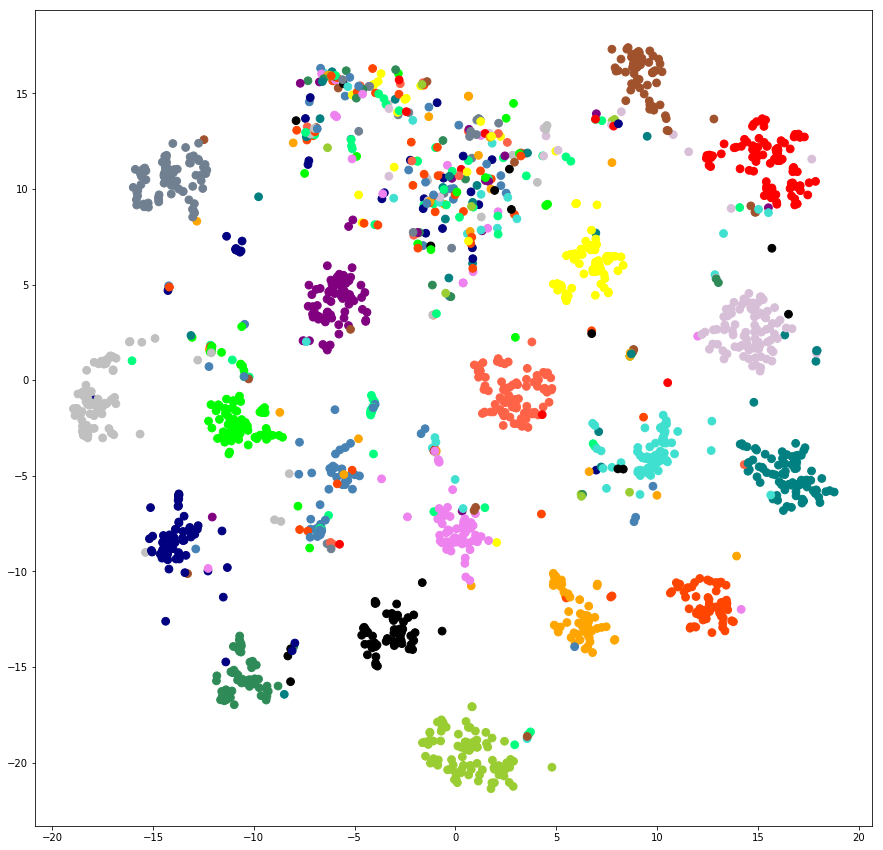

In [ ]:
plot_tsne(T)

#### T-SNE embedding on LSA

In [ ]:
%%time
L = tsne.fit_transform(LSA[:n_sample])

Wall time: 19.3 s


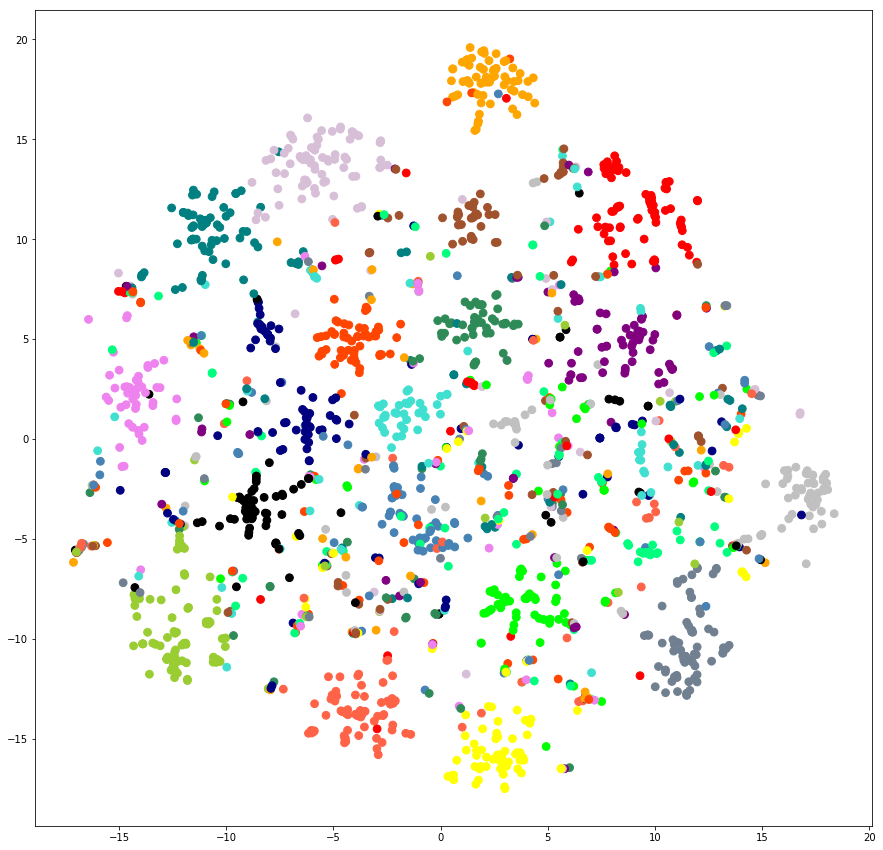

In [ ]:
# matplotlib visualization
plot_tsne(L)

# Testing K-means on laplacian eigenvalues

In [ ]:
%%time
NB = normalize(Y["le"])
km = KMeans(n_clusters=20, n_init=1)
km.fit(NB)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.514
Completeness: 0.522
V-measure: 0.518
NMI: 0.518
Rand: 0.440
Acc: 0.639
Wall time: 250 ms


In [ ]:
%%time
LE = Y["le"]
TLE = tsne.fit_transform(LE[:n_sample])

Wall time: 15.5 s


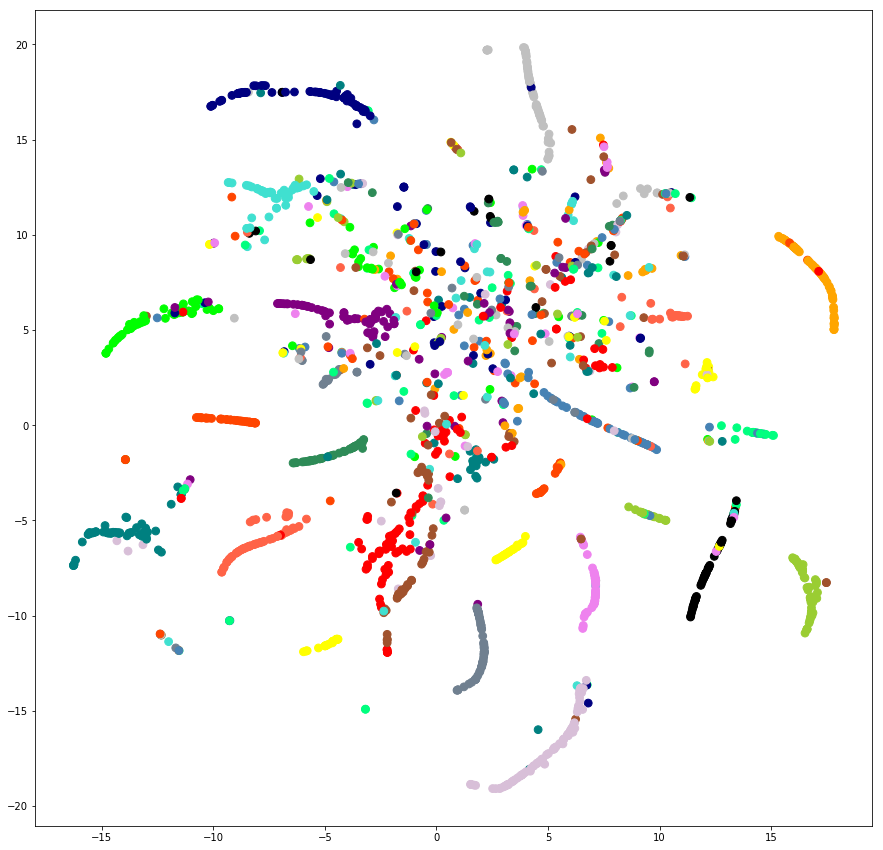

In [ ]:
plot_tsne(TLE)